In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb

In [51]:
sunspots = pd.read_csv("../../datasets/Sunspots.csv", index_col=0)

DATE_COL = sunspots.columns[0]
SUNSPOTS_COL = sunspots.columns[1]

sunspots.head(10)

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5
9,1749-10-31,125.8


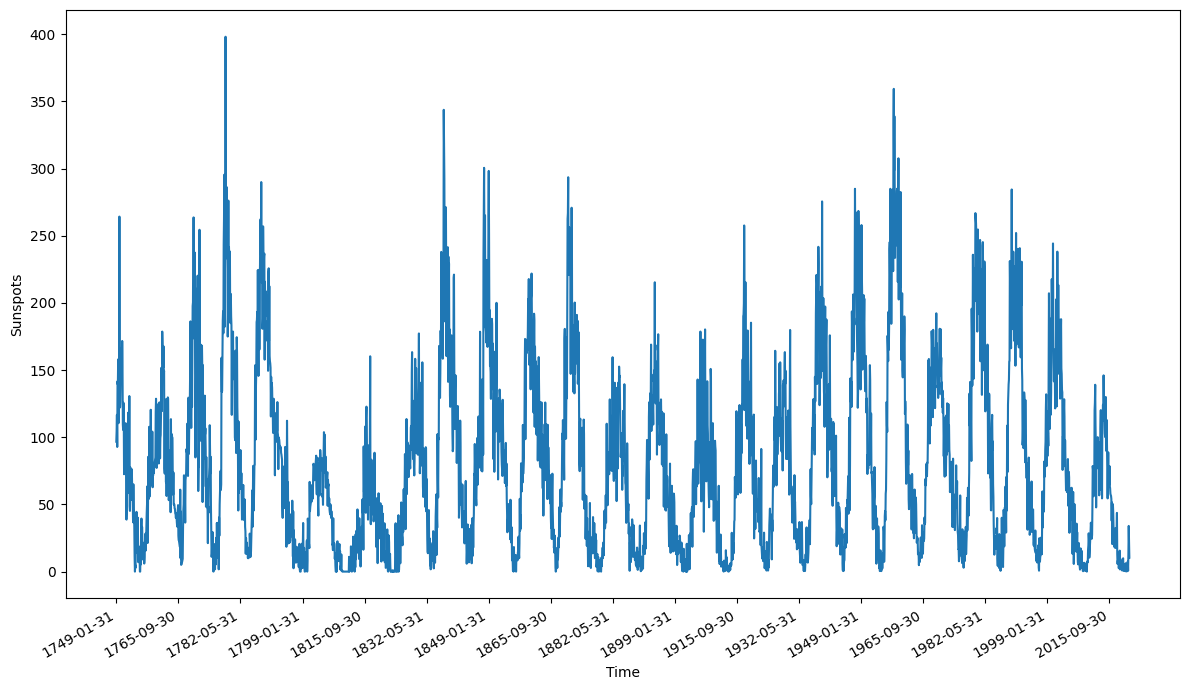

In [55]:
def plot_sunspots(data: pd.DataFrame):

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.plot(data[DATE_COL], data[SUNSPOTS_COL])
    ax.set_xticks(sunspots[DATE_COL][0::200])
    ax.set_xlabel('Time')
    ax.set_ylabel('Sunspots')
    fig.autofmt_xdate()
    plt.tight_layout()

plot_sunspots(sunspots)